In [1]:
from PIL import Image
import torch
from torch.utils.data import Dataset,TensorDataset, DataLoader,  SubsetRandomSampler
from torchvision import transforms
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [194]:


class textDataset(Dataset):
    def __init__(self, imgdir, label_encoding, transforms=False):
        #super(SynthDataset, self).__init__()
        self.path = imgdir
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        self.label_encoding = label_encoding
        self.transform = transforms
        
        #f = lambda x: os.path.join(self.path, x)
        #self.imagepaths = list(map(f, self.images))

        #self.collate_fn = SynthCollator()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        image_name = self.images[index]
 
        imagepath = os.path.join(self.path, image_name)

        img = Image.open(imagepath).convert('RGB') # 4d (+transparency layer) -> 3d 
        #img = np.array(img) # 3d -> 2d
        if self.transform:
            img = self.transform(img)
        item = {'img': img, 'idx':index}

        label = image_name.split('.')[0] #label has 5 symbols always
        label = torch.from_numpy(self.label_encoding.transform(list(label))).type(torch.long)
        item['label'] = label
        
        return item

In [61]:

unique_chars = [line.strip() for line in open("EN_symbol_dict.txt", 'r')]
VOCAB_SIZE = len(unique_chars) #  62 symbols
id_to_ch = dict(enumerate(unique_chars))
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

encoder = LabelEncoder()
encoder.fit(unique_chars)

LabelEncoder()

In [195]:

transform_list = transforms.Compose([
               #transforms.Grayscale(1),
               transforms.Resize((25, 100)),
               transforms.ToTensor()])

#transform_list = transforms.Compose([transforms.Grayscale(1),
#               transforms.Resize((64, 700)),
#               transforms.ToTensor()])
                #transforms.Normalize((0.5,), (0.5,))]

img_path = "./samples/"

dataset = textDataset(img_path,label_encoding=encoder, transforms=transform_list)

data_size = len(dataset)
validation_fraction = .25


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Notice that we create test data loader in a different way. We don't have the labels.
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


#transform_list =  [transforms.Grayscale(1),
#                    transforms.Resize((28, 28))]
#                    #transforms.ToTensor()]
                    #transforms.Normalize((0.5,), (0.5,))]
#transform2 = transforms.Compose(transform_list)


train_loader = torch.utils.data.DataLoader(dataset, batch_size=4,sampler=train_sampler, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=4, sampler=val_sampler, num_workers=0)

In [123]:
for x in train_loader:
    print(x['img'].shape, x['label'])
    break
for x in val_loader:
    print(x['img'].shape, x['label'])
    break

torch.Size([4, 3, 25, 100]) tensor([[60., 41., 49., 61., 43.],
        [60.,  4.,  7.,  3., 43.],
        [ 7., 59., 43.,  5., 50.],
        [59., 61., 39.,  3.,  6.]])
torch.Size([4, 3, 25, 100]) tensor([[40.,  8., 41., 50.,  4.],
        [60., 42.,  6., 43.,  8.],
        [40., 61., 52.,  8., 50.],
        [59., 61., 41.,  9.,  6.]])


In [64]:
for i in range(len(dataset)):
    print(dataset[1]['img'].shape)
    if i == 3:
        break

torch.Size([1, 25, 100])
torch.Size([1, 25, 100])
torch.Size([1, 25, 100])
torch.Size([1, 25, 100])


0 torch.Size([1, 25, 100]) tensor([ 3.,  3.,  7., 49., 40.])


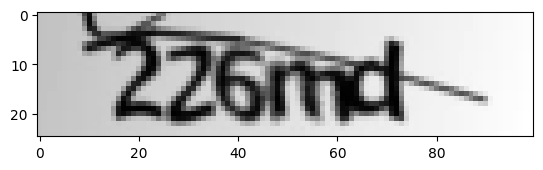

In [87]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt

for i, sample in enumerate(dataset):
    x = sample['img']
    y = sample['label']
    print(i, x.shape, y)
    #x = x.view(1,28,28)
    img_pil = to_pil_image(x)
    plt.imshow(img_pil, 'gray')
    plt.show()
    #img_pil.show()
    break

[50 60 60 42  9]
['n' 'x' 'x' 'f' '8']
(200, 50)


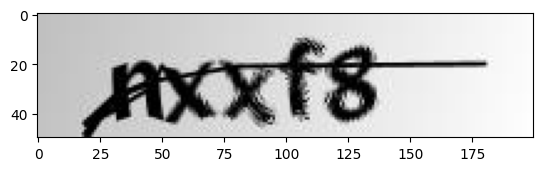

In [188]:
img = Image.open("./samples/nxxf8.png")
label = 'nxxf8'
encod_label = encoder.transform(list(label))
print(encod_label)
print(encoder.inverse_transform(encod_label))
print(img.size)
plt.imshow(img, 'gray')
plt.show()

## Model

In [124]:
import torch.nn as nn
import torch.optim as optim
import time
# import torch.nn.functional as F F.relu() for forward() 

#multi-layer perceptron (MLP) 
# MLPs cannot handle two or three-dimensional data
# Bidirectional Long Short Term Memory networks (LSTM)  model is a type of recurrent neural network (RNN) architecture that's particularly well-suited for sequence data
class MNISTLogistic(nn.Module):
    def __init__(self, N, N1, N2):
        super().__init__()
        self.fc1 = nn.Linear(2500, N)  # pytorch finds the nn.Parameters inside this nn.Module
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(N, N1)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(N1, N2)  # pytorch finds the nn.Parameters inside this nn.Module
        self.relu3 = nn.ReLU()
        #self.fc4 = nn.Linear(N2, 10)
        #self.softmax = nn.Softmax(dim=1)
        

    def forward(self, xb):
        out = self.fc1(xb)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        #out = self.fc4(out)
        #out = self.softmax(out)
        return out 

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.LSTM = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        #self.softmax = nn.Softmax(dim=1)
        self.pool = nn.AdaptiveAvgPool1d(5)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        #c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        #out, (hn, cn) = self.bilstm(x, (h0, c0))
        out, (hn, cn) = self.LSTM(x, (h0, c0))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        #out = self.softmax(out)
        out = self.pool(out)
        

        return out
        

In [66]:
#28 (assuming you're processing one row of pixels at a time)
input_dim = 100 # img size 25*100
hidden_dim = 128
layer_dim = 1 # Number of hidden recurrent layers.
output_dim = VOCAB_SIZE # 63;  26 for en characters only 

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

count_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad) #to calculate the number of trainable parameters (weights and biases) in our model
print(f'The model has {count_parameters:,} trainable parameters')

The model has 125,887 trainable parameters


In [29]:
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([512, 100])
<class 'torch.Tensor'> torch.Size([512, 128])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([63, 128])
<class 'torch.Tensor'> torch.Size([63])


In [54]:
model

LSTMModel(
  (LSTM): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=63, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=5)
)

In [55]:

#model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
loss_fn = nn.CrossEntropyLoss()

In [189]:
import torch.nn.functional as F
class Model1(torch.nn.Module):
    def __init__(self, dim, dim_out):
        super(Model1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, dim, 5, stride=2, padding=2), # (N-F)/stride +1
            nn.BatchNorm2d(dim),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(dim, dim*2, 3, padding=1),
            nn.BatchNorm2d(dim*2),
            nn.Dropout(0.1),
            nn.Conv2d(dim*2, dim*4, 3, padding=1),
            nn.BatchNorm2d(dim*4),
            nn.Dropout(0.1),
            nn.Conv2d(dim*4, dim*8, 3, padding=1)
        )
        self.fc1 = nn.Linear(dim*8*7, dim*4)
        self.rnn = nn.LSTM(dim*4, dim*2, 2, bidirectional=True, batch_first=True)
        self.fc2 = nn.Linear(dim*2*2, dim_out)
        self.pool = nn.AdaptiveAvgPool1d(5)

    def forward(self, x):
        bs, _, _, _ = x.size()
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x, _ = self.rnn(x)
        x = self.fc2(x).transpose(1, 2)
        x = self.pool(x)

        return x
model = Model1(dim=64, dim_out=63)

In [118]:
x.size()

torch.Size([4, 1, 25, 100])

In [197]:
predictions = []
targets = []
for i, batch in enumerate(train_loader):
    x, y = batch['img'], batch['label']
    
    #x = x.view(x.size(0), x.size(2), x.size(3))
    print(x.shape)
    pred = model(x)
    loss_value = loss_fn(pred, y)
    print(loss_value)
    print(pred.shape)
    out = pred.argmax(1)
    print(out.shape)
    #accuracy = 
    #encoder.inverse_transform(prediction)

    #print(list(y[0]))
    #print(y)
    break

#pred[0:]
#pred[0,:,:]
#pred

torch.Size([4, 3, 25, 100])
tensor(4.1551, grad_fn=<NllLoss2DBackward0>)
torch.Size([4, 63, 5])
torch.Size([4, 5])


In [176]:
64*2*2

256

In [44]:
pred

tensor([[-0.1108,  0.1330, -0.0094, -0.1640,  0.2175,  0.2231, -0.1106,  0.0860,
         -0.0360,  0.1636],
        [-0.1288,  0.0996, -0.0513, -0.1652,  0.2145,  0.2460, -0.1010,  0.0735,
         -0.0532,  0.1434],
        [-0.1101,  0.0821, -0.0456, -0.1347,  0.2189,  0.2388, -0.1025,  0.0455,
         -0.0802,  0.1400],
        [-0.1321,  0.1055, -0.0285, -0.1437,  0.2355,  0.2677, -0.1201,  0.0609,
         -0.0257,  0.1537]], grad_fn=<AddmmBackward0>)

## Train model

In [200]:
device = 'cpu'
def accuracy(out: torch.Tensor, yb: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def compute_val_accuracy(model, val_loader):
    val_acc = 0
    for i, batch in enumerate(val_loader):
        x, y = batch['img'], batch['label']
        #x = x.view(x.size(0), x.size(2), x.size(3))
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        val_acc += accuracy(pred, y)
    return (val_acc.float()/i)

def train(model, dataloader, val_loader, loss_fn, opt, num_epoch, report_accuracy=True):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epoch):
        model.train()

        train_acc = 0
        train_loss_accum = 0
        
        for i, batch in enumerate(dataloader):
            x, y = batch['img'], batch['label']
            #x = x.view(x.size(0), x.size(2), x.size(3))

            x = x.to(device)
            y = y.to(device)

            opt.zero_grad()

            pred = model(x)
            loss_value = loss_fn(pred, y)
            train_loss_accum += loss_value.item()

            loss_value.backward()
            opt.step()
            
            if report_accuracy:
                train_acc += accuracy(pred, y)

        
        model.eval()
        with torch.no_grad():
            val_accuracy = compute_val_accuracy(model, val_loader)

        ave_loss = train_loss_accum / i
        train_accuracy = float(train_acc) / i
        
        loss_history.append(float(ave_loss))  
        train_history.append(float(train_accuracy))
        val_history.append(float(val_accuracy))
            
            
        print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))

In [201]:

train(model, train_loader, val_loader, loss_fn, optimizer, num_epoch=5)

Epoch: 0, Average loss: 4.170709, Train accuracy: 0.000000, Val accuracy: 0.000000
Epoch: 1, Average loss: 4.170676, Train accuracy: 0.000000, Val accuracy: 0.000000
Epoch: 2, Average loss: 4.170805, Train accuracy: 0.000000, Val accuracy: 0.000000
Epoch: 3, Average loss: 4.170847, Train accuracy: 0.000000, Val accuracy: 0.000000
Epoch: 4, Average loss: 4.170756, Train accuracy: 0.000000, Val accuracy: 0.000000
